# 6  基于MindSpore实现一维线性回归

本实验主要介绍使用MindSpore实现一维线性回归，并使用自定义数据集进行测试。

# 1 实验目的
- 掌握一维线性回归原理。
- 了解如何使用MindSpore进行一维线性回归模型的开发。
- 了解如何使用一维线性回归模型对数据进行拟合。

# 2 一维线性回归模型知识点介绍
回归是基于已有数据对新的数据的进行预测，根据历史信息预测当前信息。  
<img src="Figures/fig_003.png" width="40%" >  
一维线性回归适用于自变量 $x$ 和因变量 $y$ 之间存在线性关系的数据集，可以使用一条直线来拟合数据，使数据集中所有数据点到拟合直线的距离最小。
在一维线性回归中，因变量与自变量呈线性关系：  
$$
y = w \cdot x + b
$$  
通过一维线性回归模型寻找到一条合适的直线，最大程度地拟合自变量 $x$ 和因变量 $y$ 之间的关系，这样我们已知一个 $x$ 的值，就可以通过这条拟合直线找到最可能的 $y$ 值。
在后续实验过程中，需要借助MindSpore的神经网络模块（mindspore.nn）来实现一维线性回归模型。在深度学习中，我们可以使用神经网络图直观地表示线性结构，假设现在有一个单层神经网络，隐去模型参数权重和偏置之后，如下图所示：

![单层神经网络](./Figures/fig_004.png)  
图中所示神经网络中，输入分别为x1和x2，因此输入层的输入个数为2。输入个数被称为特征数或特征向量维度。输出为o，输出层的输出个数为1。因此如图所示神经网络实质上是一个二维线性回归模型。如果输入层的输入个数为1，那么实际上是一个一维线性回归模型。  
有了以上理论依据，我们在后续实验中可以借助于神经网络模块来实现一维线性回归模型。


# 3 实验环境
在动手进行实践之前，需要注意以下几点：
* 确保实验环境正确安装，包括安装MindSpore。安装过程：首先登录[MindSpore官网安装页面](https://www.mindspore.cn/install)，根据安装指南下载安装包及查询相关文档。同时，官网环境安装也可以按下表说明找到对应环境搭建文档链接，根据环境搭建手册配置对应的实验环境。
* 推荐使用交互式的计算环境Jupyter Notebook，其交互性强，易于可视化，适合频繁修改的数据分析实验环境。
* 实验也可以在华为云一站式的AI开发平台ModelArts上完成。
* 推荐实验环境：MindSpore版本=1.8；Python环境=3.7


|  硬件平台 |  操作系统  | 软件环境 | 开发环境 | 环境搭建链接 |
| :-----:| :----: | :----: |:----:   |:----:   |
| CPU | Windows-x64 | MindSpore1.8 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.1节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| GPU CUDA 10.1|Linux-x86_64| MindSpore1.8 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第二章2.2节和第三章3.1节](./MindSpore环境搭建实验手册.docx)|
| Ascend 910  | Linux-x86_64| MindSpore1.8 Python3.7.5 | JupyterNotebook |[MindSpore环境搭建实验手册第四章](./MindSpore环境搭建实验手册.docx)|

# 4 数据处理
## 4.1 数据准备
调用numpy接口随机生成自变量 $x$, 根据自定义函数加入随机噪声后生成因变量 $y$, 数据形式如下所示：  
$$
[<x_1, y_1>, <x_2,y_2>, \dots ,<x_n,y_n>] 
$$

## 4.2 数据加载
#### 代码如下：  

In [1]:
# 导入numpy包
import numpy as np
# 自定义数据集生成函数
def get_data(num,w=2,b=3):
    for data in range(num):
        # 在一定范围内随机生成自变量
        x=np.random.uniform(-10,10)
        # 生成随机噪声
        noise=np.random.normal(0,1)
        # 加入噪声之后得到因变量
        y=x*w+b+noise
        # 返回数据
        yield np.array([x]).astype(np.float32),np.array([y]).astype(np.float32)

# 展示部分数据
eval_data=list(get_data(6))
x_eval_label,y_eval_label=zip(*eval_data)
eval_data

[(array([1.208284], dtype=float32), array([7.186478], dtype=float32)),
 (array([-6.7044067], dtype=float32), array([-10.228051], dtype=float32)),
 (array([2.594381], dtype=float32), array([7.8333526], dtype=float32)),
 (array([0.36282966], dtype=float32), array([4.2850647], dtype=float32)),
 (array([-0.26227695], dtype=float32), array([2.8615186], dtype=float32)),
 (array([0.871694], dtype=float32), array([3.0053587], dtype=float32))]

#### 部分数据展示：  
![部分数据展示](Figures/fig_001.png)

# 5 模型构建
## 5.1 导入python库

In [13]:
# 引入time模块
import time
# 引入numpy科学计算库
import numpy as np
# 引入绘图库
import matplotlib.pyplot as plt
# 引入MindSpore库
import mindspore 
# 神经网络模块
import mindspore.nn as nn
# 常见算子模块
import mindspore.ops as ops
# 张量,参数和参数元组
from mindspore import Tensor, ParameterTuple, Parameter 
# 数据类型
from mindspore import dtype as mstype
# 数据集
from mindspore import dataset as ds
# 引入Normal接口
from mindspore.common.initializer import Normal
# 引入Model模块
from mindspore import Model
# 引入LossMonitor模块
from mindspore.train.callback import LossMonitor
# display模块
from IPython import display
# 引入回调函数
from mindspore.train.callback import Callback
# 设置随机数生成种子 
np.random.seed(123)

## 5.2 生成数据集

In [5]:
# 数据集生成函数
def create_dataset(num_data,batch_size=16,repeat_size=1):
    input_data=ds.GeneratorDataset(list(get_data(num_data)),column_names=['data','label'])
    # 设置数据批次
    input_data=input_data.batch(batch_size) 
    # 设置数据重复次数
    input_data=input_data.repeat(repeat_size) 
    return input_data

data_number=1600         # 数据数量
batch_number=16          # 数据批次
repeat_number=1          # 数据重复次数
# 生成数据集
ds_train=create_dataset(data_number,batch_number,repeat_number)
# 打印数据集批次
print('数据集批次：',ds_train.get_dataset_size())
# 创建数据集字典
dict_datasets=next(ds_train.create_dict_iterator())
# 打印数据集信息
print(dict_datasets.keys())
print('X:',dict_datasets['data'].shape)
print('y:',dict_datasets['label'].shape)

数据集批次： 100
dict_keys(['data', 'label'])
X: (16, 1)
y: (16, 1)


## 5.3 构建一维线性回归模型

In [7]:
# 定义一个简单的一维线性回归模型
class LinearNet(nn.Cell):
    # 定义线性层
    def __init__(self):
        super(LinearNet,self).__init__()
        # 使用全连接层表示一维线性回归模型，初始化权重和偏置
        self.fc=nn.Dense(1,1,Normal(0.02),Normal(0.02),has_bias=True) 
    # 构造函数
    def construct(self,x):
        x=self.fc(x)
        return x

## 5.4 定义损失函数、优化器

In [10]:
# 一维线性回归模型实例化
net=LinearNet()
# 定义损失函数
net_loss=nn.loss.MSELoss()
# 传入模型的训练参数，以及学习率等参数
opt=nn.Momentum(net.trainable_params(),learning_rate=0.005,momentum=0.9)
# 定义模型
model=Model(net,net_loss,opt)
# 打印模型中的参数维度形状信息
model_params=net.trainable_params()
for param in model_params:
    print(param,param.asnumpy())

Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[-0.02515898]]
Parameter (name=fc.bias, shape=(1,), dtype=Float32, requires_grad=True) [-0.01981865]


# 6.模型训练
## 6.1 可视化

In [15]:
# 定义函数画出模型拟合之直线以及真实的数据拟合直线的对比
def plot_model_and_datasets(net, eval_data):
    # 权重
    weight = net.trainable_params()[0]
    # 偏置
    bias = net.trainable_params()[1]
    x = np.arange(-10, 10, 0.1)
    y = x * Tensor(weight).asnumpy()[0][0] + Tensor(bias).asnumpy()[0]
    x1, y1 = zip(*eval_data)
    x_target = x
    y_target = x_target * 2 + 3
    # 绘制图像
    plt.axis([-11, 11, -20, 25])
    plt.scatter(x1, y1, color="red", s=5)
    plt.plot(x, y, color="blue")
    plt.plot(x_target, y_target, color="green")
    plt.show()
# 定义回调函数，训练过程中画出模型拟合的曲线
class ImageShowCallback(Callback):
    # 初始化
    def __init__(self, net, eval_data):
        self.net = net
        self.eval_data = eval_data
    # 绘制图像
    def step_end(self, run_context):
        plot_model_and_datasets(self.net, self.eval_data)
        # 清除打印内容，实现动态拟合效果
        display.clear_output(wait=True)

## 6.2 训练

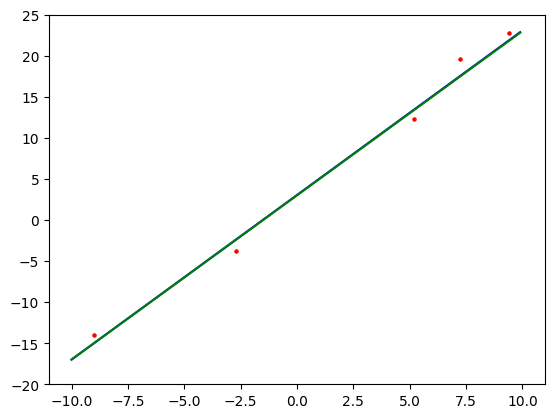

In [16]:
# 训练回合数
epoch = 1
# 绘制训练过程中拟合直线图像
imageshow_cb = ImageShowCallback(net, eval_data)
# 开始训练
model.train(epoch, ds_train, callbacks=[imageshow_cb], dataset_sink_mode=False)

# 7. 模型预测

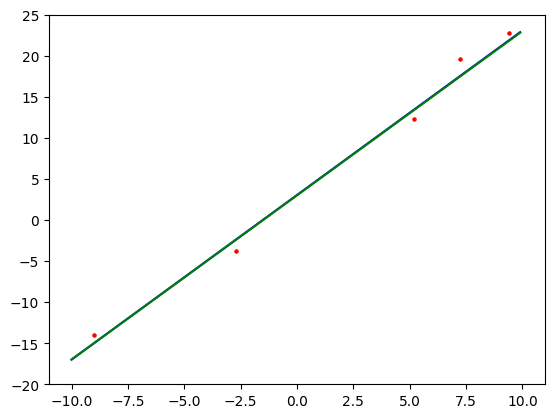

Parameter (name=fc.weight, shape=(1, 1), dtype=Float32, requires_grad=True) [[2.0032113]]
Parameter (name=fc.bias, shape=(1,), dtype=Float32, requires_grad=True) [3.040953]


In [17]:
# 传入线性回归模型和数据
plot_model_and_datasets(net, eval_data)
# 打印模型参数和训练结果
for net_param in net.trainable_params():
    print(net_param, net_param.asnumpy())